# Classify Maps as User or Tiledriver Created

In [1]:
# %load metamaps.py
"""Provides methods for loading/saving metamaps"""
import struct
from enum import IntEnum
from keras.utils import Sequence
import numpy as np
import os
import random
import numbers

METAMAP_FILE_VERSION = 0x100

class TileType(IntEnum):
    """Tile types in a metamap"""
    UNREACHABLE = 0
    EMPTY = 1
    WALL = 2
    PUSHWALL = 3
    DOOR = 4

class EncodingDim(IntEnum):
    """Dimensions for the one-hot encoding of a metamap"""
    PLAYABLE = 0
    SOLID = 1
    PASSAGE = 2

TileTypeToEncodingDim = {
    TileType.UNREACHABLE: EncodingDim.SOLID,
    TileType.EMPTY: EncodingDim.PLAYABLE,
    TileType.WALL: EncodingDim.SOLID,
    TileType.PUSHWALL: EncodingDim.PASSAGE,
    TileType.DOOR: EncodingDim.PASSAGE,
    }

class MetaMapsSequence(Sequence):
    """A sequence of real metamaps from a directory and randomly generated ones"""

    def __init__(self, maps_dir, batch_size):
        self.maps_dir = maps_dir
        self.batch_size = batch_size
        self.map_files = os.listdir(maps_dir)
        NUM_MAPS = len(self.map_files)
        real_maps = [(index, True) for index in range(NUM_MAPS)]
        fake_maps = [(index + NUM_MAPS, False) for index in range(NUM_MAPS)]
        map_order = real_maps + fake_maps
        np.random.shuffle(map_order)
        self.map_order = map_order

    def __len__(self):
        return int(len(self.map_order) / self.batch_size)

    def __getitem__(self, idx):
        map_batch = np.zeros((self.batch_size, 64, 64, len(EncodingDim)))
        label_batch = np.zeros((self.batch_size))

        for i in range(self.batch_size):
            (index, real_map) = self.map_order[idx * self.batch_size + i]
            if real_map:
                label_batch[i] = 1
                map_batch[i:] = load_metamap(
                    os.path.join(self.maps_dir, self.map_files[index]))
            else:
                map_batch[i:] = generate_random_map()

        return map_batch, label_batch


def generate_random_map():
    """Generate a random map"""
    width = 64
    height = 64
    size = width * height

    junk_map = np.zeros([size, len(EncodingDim)])

    for i in range(size):
        tile_type = random.randint(0, len(EncodingDim) - 1)
        junk_map[i, tile_type] = 1

    junk_map.shape = (width, height, len(EncodingDim))

    return junk_map


def load_all_metamaps(dirname, number_cap=None):
    """Loads all the metamaps in the given directory, returning a giant numpy array"""
    map_names = os.listdir(dirname)
    if isinstance(number_cap, numbers.Integral) and number_cap > 0:
        map_names = map_names[:number_cap]
    all_maps = np.zeros((len(map_names), 64, 64, len(EncodingDim)))

    for index, map_name in enumerate(map_names):
        load_metamap_into(os.path.join(dirname, map_name), all_maps, index)

    return all_maps


def load_metamap_into(filename, all_maps, index):
    """Loads a metamap from a file into a numpy array of shape (width, height, 3)"""
    with open(filename, "rb") as fin:
        version = struct.unpack('Q', fin.read(8))[0]

        if version != METAMAP_FILE_VERSION:
            raise ValueError("Unsupported metamap version")

        width = struct.unpack('i', fin.read(4))[0]
        height = struct.unpack('i', fin.read(4))[0]

        raw_map = np.fromfile(fin, dtype=np.uint8)
        raw_map.shape = (width, height)

        for y in range(height):
            for x in range(width):
                tile_type = TileType(raw_map[y, x])
                all_maps[index, y, x, TileTypeToEncodingDim[tile_type]] = 1


def load_metamap(filename):
    """Loads a metamap from a file into a numpy array of shape (width, height, 3)"""
    with open(filename, "rb") as fin:
        version = struct.unpack('Q', fin.read(8))[0]

        if version != METAMAP_FILE_VERSION:
            raise ValueError("Unsupported metamap version")

        width = struct.unpack('i', fin.read(4))[0]
        height = struct.unpack('i', fin.read(4))[0]
        size = width * height

        raw_map = np.fromfile(fin, dtype=np.uint8)
        one_hot = np.zeros([size, len(EncodingDim)])

        for i in range(size):
            tile_type = TileType(raw_map[i])
            one_hot[i, TileTypeToEncodingDim[tile_type]] = 1

        one_hot.shape = (width, height, len(EncodingDim))

        return one_hot


def save_metamap(metamap, filename):
    """Saves a metamap to a file"""
    with open(filename, "wb") as fout:
        fout.write(struct.pack('Q', METAMAP_FILE_VERSION))

        width = metamap.shape[0]
        height = metamap.shape[1]

        fout.write(struct.pack('i', width))
        fout.write(struct.pack('i', height))
        for y in range(height):
            for x in range(width):
                tile_type = TileType.WALL
                if metamap[y, x, EncodingDim.PLAYABLE] == 1:
                    tile_type = TileType.EMPTY
                elif metamap[y, x, EncodingDim.SOLID] == 1:
                    tile_type = TileType.WALL
                elif metamap[y, x, EncodingDim.PASSAGE] == 1:
                    tile_type = TileType.DOOR

                fout.write(struct.pack('b', tile_type))
    return

C:\Users\david\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Set Up File Paths

In [2]:
import os
import shutil
import numpy as np

In [3]:
user_original_dir = 'metamaps_user'
fake_original_dir = 'metamaps_tiledriver'

base_dir = 'metamaps_mix'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

user_train_dir = os.path.join(train_dir, 'user')
user_validation_dir = os.path.join(validation_dir, 'user')
user_test_dir = os.path.join(test_dir, 'user')

fake_train_dir = os.path.join(train_dir, 'fake')
fake_validation_dir = os.path.join(validation_dir, 'fake')
fake_test_dir = os.path.join(test_dir, 'fake')

def show_number_of_files_in_dir(dirname):
    print("Num files in '{}': {}".format(dirname,len(os.listdir(dirname))))

In [4]:
show_number_of_files_in_dir(user_original_dir)
show_number_of_files_in_dir(fake_original_dir)

Num files in 'metamaps_user': 34257
Num files in 'metamaps_tiledriver': 34257


# Reset input directory

shutil.rmtree(base_real_dir)
shutil.rmtree(base_fake_dir)

# Create Input Directory Structure and Copy Maps

In [5]:
def safe_create(dirname):
    if not os.path.exists(dirname):
        print("Creating '{}'".format(dirname))
        os.mkdir(dirname)
    else:
        print("'{}' already exists".format(dirname))

safe_create(base_dir)

safe_create(train_dir)
safe_create(validation_dir)
safe_create(test_dir)

safe_create(user_train_dir)
safe_create(user_validation_dir)
safe_create(user_test_dir)

safe_create(fake_train_dir)
safe_create(fake_validation_dir)
safe_create(fake_test_dir)

'metamaps_mix' already exists
'metamaps_mix\train' already exists
'metamaps_mix\validation' already exists
'metamaps_mix\test' already exists
'metamaps_mix\train\user' already exists
'metamaps_mix\validation\user' already exists
'metamaps_mix\test\user' already exists
'metamaps_mix\train\fake' already exists
'metamaps_mix\validation\fake' already exists
'metamaps_mix\test\fake' already exists


In [6]:
# Randomize the list of files
user_input_files = os.listdir(user_original_dir)
np.random.shuffle(user_input_files)

fake_input_files = os.listdir(fake_original_dir)
np.random.shuffle(fake_input_files)

In [7]:
BUCKET_SIZE = 8500

def copy_bucket_of_maps(input_files,original_dir,start_bucket,num_buckets,dest_dir):
    if len(os.listdir(dest_dir)) == 0:
        print("Copying {} files into '{}'".format(num_buckets*BUCKET_SIZE, dest_dir))
        start = start_bucket * BUCKET_SIZE
        end = (start_bucket + num_buckets) * BUCKET_SIZE
        for fname in input_files[start:end]:
            src = os.path.join(original_dir, fname)
            dst = os.path.join(dest_dir, fname)
            shutil.copyfile(src, dst)
    else:
        print("Skipped copying files into '{}'".format(dest_dir))

In [8]:
# Copy two buckets worth of metamaps images to train dir
copy_bucket_of_maps(user_input_files,user_original_dir,0,2,user_train_dir)
copy_bucket_of_maps(fake_input_files,fake_original_dir,0,2,fake_train_dir)

# Copy next bucket of metamaps to validation dir
copy_bucket_of_maps(user_input_files,user_original_dir,2,1,user_validation_dir)
copy_bucket_of_maps(fake_input_files,fake_original_dir,2,1,fake_validation_dir)

# Copy next bucket of metamaps to test dir
copy_bucket_of_maps(user_input_files,user_original_dir,3,1,user_test_dir)
copy_bucket_of_maps(fake_input_files,fake_original_dir,3,1,fake_test_dir)

NUM_REAL_TRAIN_MAPS = 2 * BUCKET_SIZE
NUM_REAL_VALIDATION_MAPS = BUCKET_SIZE
NUM_REAL_TEST_MAPS = BUCKET_SIZE

Skipped copying files into 'metamaps_mix\train\user'
Skipped copying files into 'metamaps_mix\train\fake'
Skipped copying files into 'metamaps_mix\validation\user'
Skipped copying files into 'metamaps_mix\validation\fake'
Skipped copying files into 'metamaps_mix\test\user'
Skipped copying files into 'metamaps_mix\test\fake'


## Verify number of files in input directories

### User Maps

In [9]:
show_number_of_files_in_dir(user_train_dir)
show_number_of_files_in_dir(user_validation_dir)
show_number_of_files_in_dir(user_test_dir)

Num files in 'metamaps_mix\train\user': 17000
Num files in 'metamaps_mix\validation\user': 8500
Num files in 'metamaps_mix\test\user': 8500


### Fake Maps

In [10]:
show_number_of_files_in_dir(fake_train_dir)
show_number_of_files_in_dir(fake_validation_dir)
show_number_of_files_in_dir(fake_test_dir)

Num files in 'metamaps_mix\train\fake': 17000
Num files in 'metamaps_mix\validation\fake': 8500
Num files in 'metamaps_mix\test\fake': 8500


# Load Maps

In [11]:
user_train_maps = load_all_metamaps(user_train_dir, number_cap=1000)

In [12]:
fake_train_maps = load_all_metamaps(fake_train_dir, number_cap=1000)

In [13]:
user_validation_maps = load_all_metamaps(user_validation_dir, number_cap=500)

In [14]:
fake_validation_maps = load_all_metamaps(fake_validation_dir, number_cap=500)

## Join training maps, shuffle, and make map + label lists

In [15]:
USER_MAPS_LABEL=1
FAKE_MAPS_LABEL=0

def create_shuffled_maps_and_labels(user_maps, fake_maps):
    user_labels = [USER_MAPS_LABEL] * len(user_maps)
    fake_labels = [FAKE_MAPS_LABEL] * len(fake_maps)
    all_maps = np.concatenate([user_maps, fake_maps])
    all_labels = np.concatenate([user_labels, fake_labels])
    p = np.random.permutation(len(all_maps))
    return all_maps[p], all_labels[p]

In [16]:
train_maps, train_labels = create_shuffled_maps_and_labels(user_train_maps, fake_train_maps)

In [17]:
validation_maps, validation_labels = create_shuffled_maps_and_labels(user_validation_maps, fake_validation_maps)

In [18]:
train_labels

array([0, 1, 1, ..., 0, 1, 1])

# Create model and add layers

In [28]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.SeparableConv2D(32, (3, 3), activation='relu',
                        input_shape=(64, 64, len(EncodingDim))))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.SeparableConv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.SeparableConv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_4 (Separabl (None, 62, 62, 32)        155       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 29, 29, 64)        2400      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
separable_conv2d_6 (Separabl (None, 12, 12, 128)       8896      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
__________

In [30]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [31]:
history = model.fit(
    x=train_maps,
    y=train_labels,
    batch_size=20,
    epochs=15,
    validation_data=(validation_maps, validation_labels)) 

Train on 2000 samples, validate on 1000 samples
Epoch 1/15
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6225 - acc: 0.6800 - val_loss: 0.5137 - val_acc: 0.8030
Epoch 2/15
2000/2000 [==============================] - 18s 9ms/step - loss: 0.4487 - acc: 0.8370 - val_loss: 0.3697 - val_acc: 0.8770
Epoch 3/15
2000/2000 [==============================] - 18s 9ms/step - loss: 0.3864 - acc: 0.8425 - val_loss: 0.3397 - val_acc: 0.8770
Epoch 4/15
2000/2000 [==============================] - 18s 9ms/step - loss: 0.3656 - acc: 0.8550 - val_loss: 0.3432 - val_acc: 0.8470
Epoch 5/15
2000/2000 [==============================] - 18s 9ms/step - loss: 0.3559 - acc: 0.8500 - val_loss: 0.3173 - val_acc: 0.8760
Epoch 6/15
2000/2000 [==============================] - 18s 9ms/step - loss: 0.3443 - acc: 0.8560 - val_loss: 0.3066 - val_acc: 0.8760
Epoch 7/15
2000/2000 [==============================] - 19s 9ms/step - loss: 0.3341 - acc: 0.8620 - val_loss: 0.2991 - val_acc: 0.8800
Epoch 8

In [32]:
model.save('user_vs_tiledriver_metamaps.h5')

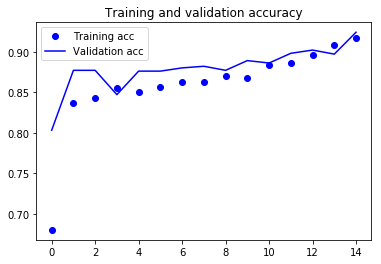

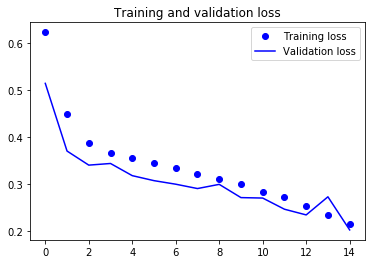

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()